### All libraries we need

In [1]:
import argparse
import glob
import os
import time
import sys
import matplotlib.pyplot as plt
import networkx as nx


import torch
import torch.nn as nn
import torch.nn.functional as F

from sparse_softmax import Sparsemax
from torch.nn import Parameter
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.pool.topk_pool import topk, filter_adj
from torch_geometric.utils import softmax, dense_to_sparse, add_remaining_self_loops
from torch_scatter import scatter_add
from torch_sparse import spspmm, coalesce
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv

from utils import *

In [5]:
import sys
sys.argv=['']
del sys

parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--batch_size', type=int, default=512, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--sample_neighbor', type=bool, default=True, help='whether sample neighbors')
parser.add_argument('--sparse_attention', type=bool, default=True, help='whether use sparse attention')
parser.add_argument('--structure_learning', type=bool, default=True, help='whether perform structure learning')
parser.add_argument('--pooling_ratio', type=float, default=0.5, help='pooling ratio')
parser.add_argument('--dropout_ratio', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--lamb', type=float, default=1.0, help='trade-off parameter')
parser.add_argument('--dataset', type=str, default='PROTEINS', help='DD/PROTEINS/NCI1/NCI109/Mutagenicity/ENZYMES')
parser.add_argument('--device', type=str, default='cuda:0', help='specify cuda devices')
parser.add_argument('--epochs', type=int, default=50, help='maximum number of epochs')
parser.add_argument('--patience', type=int, default=100, help='patience for early stopping')

args = parser.parse_args()
torch.manual_seed(args.seed)

### Load Dataset

In [6]:
dataset = TUDataset(os.path.join('data', args.dataset), name=args.dataset, use_node_attr=True)

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

Namespace(seed=777, batch_size=512, lr=0.001, weight_decay=0.001, nhid=128, sample_neighbor=True, sparse_attention=True, structure_learning=True, pooling_ratio=0.5, dropout_ratio=0.0, lamb=1.0, dataset='PROTEINS', device='cuda:0', epochs=50, patience=100, num_classes=2, num_features=4)


### Visualization

#### For visualization load dataset from dgl library


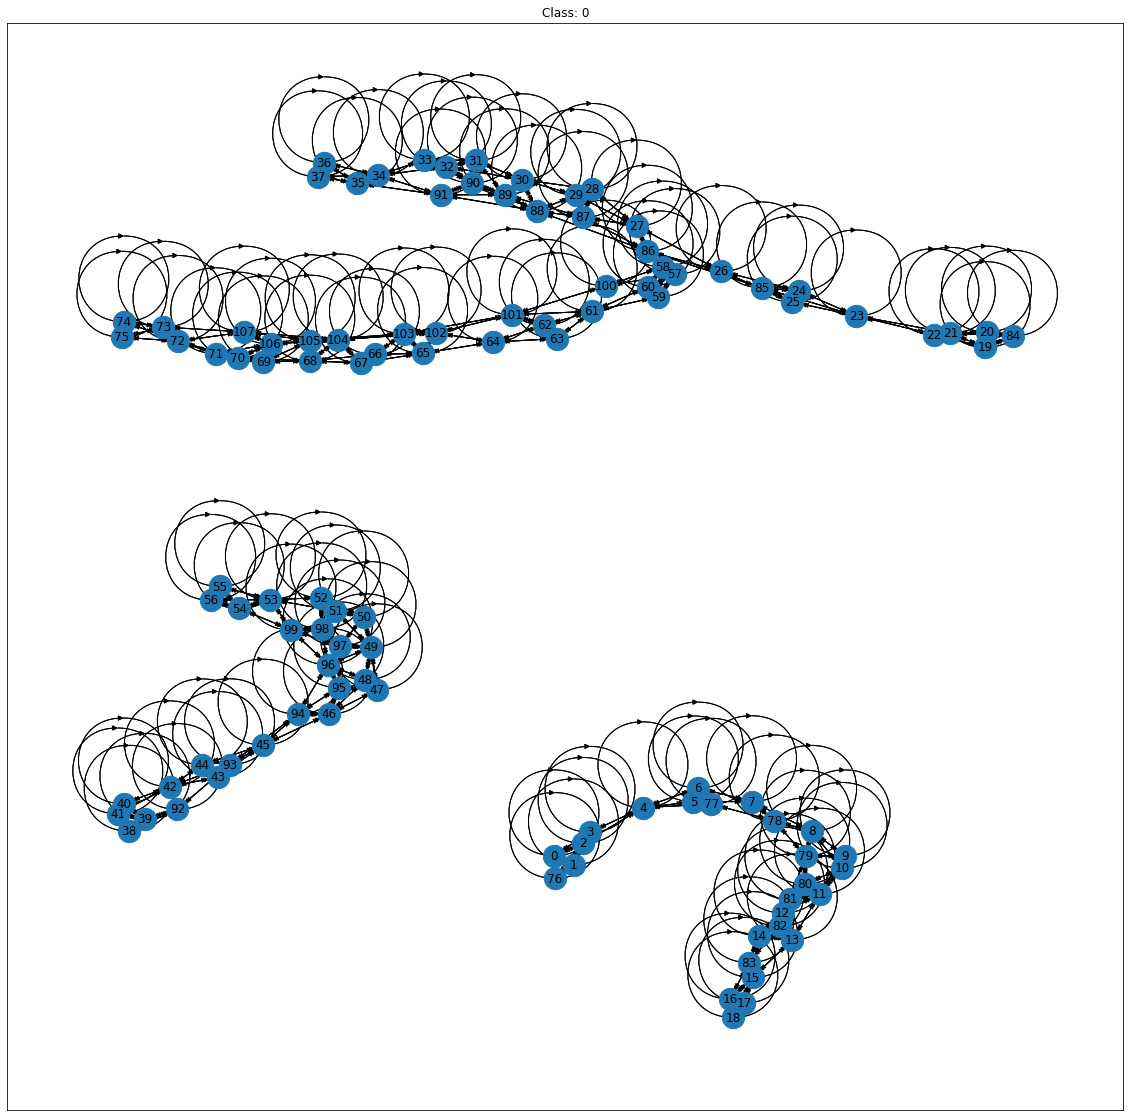

In [3]:
# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
import dgl
import dgl.data

dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)
g, label = dataset[6]

# Create a NetworkX graph from the DGL graph
g_nx = g.to_networkx()
# Create a plot
plt.figure(figsize=(20,20))
# Draw the graph
pos = nx.spring_layout(g_nx)  # Specifying the layout of the graph
nx.draw_networkx(g_nx, pos=pos, with_labels=True, node_size=500)
# Plot the edges
nx.draw_networkx_edges(g_nx, pos=pos)
plt.title('Class: {:d}'.format(label))
# Show the plot
plt.show()

### Dataloader

In [7]:
num_training = int(len(dataset) * 0.8)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

train_loader = DataLoader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Training Process

In [8]:


class TwoHopNeighborhood(object):
    def __call__(self, data):
        edge_index, edge_attr = data.edge_index, data.edge_attr
        n = data.num_nodes

        fill = 1e16
        value = edge_index.new_full((edge_index.size(1),), fill, dtype=torch.float)

        index, value = spspmm(edge_index, value, edge_index, value, n, n, n, True)

        edge_index = torch.cat([edge_index, index], dim=1)
        if edge_attr is None:
            data.edge_index, _ = coalesce(edge_index, None, n, n)
        else:
            value = value.view(-1, *[1 for _ in range(edge_attr.dim() - 1)])
            value = value.expand(-1, *list(edge_attr.size())[1:])
            edge_attr = torch.cat([edge_attr, value], dim=0)
            #, fill_value=fill
            data.edge_index, edge_attr = coalesce(edge_index, edge_attr, n, n, op='min')
            edge_attr[edge_attr >= fill] = 0
            data.edge_attr = edge_attr

        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)


class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels, cached=False, bias=True, **kwargs):
        super(GCN, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.cached = cached
        self.cached_result = None
        self.cached_num_edges = None

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))
        nn.init.xavier_uniform_(self.weight.data)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
            nn.init.zeros_(self.bias.data)
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.cached_result = None
        self.cached_num_edges = None

    @staticmethod
    def norm(edge_index, num_nodes, edge_weight, dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype, device=edge_index.device)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    def forward(self, x, edge_index, edge_weight=None):
        x = torch.matmul(x, self.weight)

        if self.cached and self.cached_result is not None:
            if edge_index.size(1) != self.cached_num_edges:
                raise RuntimeError(
                    'Cached {} number of edges, but found {}'.format(self.cached_num_edges, edge_index.size(1)))

        if not self.cached or self.cached_result is None:
            self.cached_num_edges = edge_index.size(1)
            edge_index, norm = self.norm(edge_index, x.size(0), edge_weight, x.dtype)
            self.cached_result = edge_index, norm

        edge_index, norm = self.cached_result

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)


class NodeInformationScore(MessagePassing):
    def __init__(self, improved=False, cached=False, **kwargs):
        super(NodeInformationScore, self).__init__(aggr='add', **kwargs)

        self.improved = improved
        self.cached = cached
        self.cached_result = None
        self.cached_num_edges = None

    @staticmethod
    def norm(edge_index, num_nodes, edge_weight, dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype, device=edge_index.device)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        edge_index, edge_weight = add_remaining_self_loops(edge_index, edge_weight, 0, num_nodes)

        row, col = edge_index
        expand_deg = torch.zeros((edge_weight.size(0),), dtype=dtype, device=edge_index.device)
        expand_deg[-num_nodes:] = torch.ones((num_nodes,), dtype=dtype, device=edge_index.device)

        return edge_index, expand_deg - deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    def forward(self, x, edge_index, edge_weight):
        if self.cached and self.cached_result is not None:
            if edge_index.size(1) != self.cached_num_edges:
                raise RuntimeError(
                    'Cached {} number of edges, but found {}'.format(self.cached_num_edges, edge_index.size(1)))

        if not self.cached or self.cached_result is None:
            self.cached_num_edges = edge_index.size(1)
            edge_index, norm = self.norm(edge_index, x.size(0), edge_weight, x.dtype)
            self.cached_result = edge_index, norm

        edge_index, norm = self.cached_result

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out


class HGPSLPool(torch.nn.Module):
    def __init__(self, in_channels, ratio=0.8, sample=False, sparse=False, sl=True, lamb=1.0, negative_slop=0.2):
        super(HGPSLPool, self).__init__()
        self.in_channels = in_channels
        self.ratio = ratio
        self.sample = sample
        self.sparse = sparse
        self.sl = sl
        self.negative_slop = negative_slop
        self.lamb = lamb

        self.att = Parameter(torch.Tensor(1, self.in_channels * 2))
        nn.init.xavier_uniform_(self.att.data)
        self.sparse_attention = Sparsemax()
        self.neighbor_augment = TwoHopNeighborhood()
        self.calc_information_score = NodeInformationScore()

    def forward(self, x, edge_index, edge_attr, batch=None):
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))

        x_information_score = self.calc_information_score(x, edge_index, edge_attr)
        score = torch.sum(torch.abs(x_information_score), dim=1)

        # Graph Pooling
        original_x = x
        perm = topk(score, self.ratio, batch)
        x = x[perm]
        batch = batch[perm]
        induced_edge_index, induced_edge_attr = filter_adj(edge_index, edge_attr, perm, num_nodes=score.size(0))

        # Discard structure learning layer, directly return
        if self.sl is False:
            return x, induced_edge_index, induced_edge_attr, batch

        # Structure Learning
        if self.sample:
            # A fast mode for large graphs.
            # In large graphs, learning the possible edge weights between each pair of nodes is time consuming.
            # To accelerate this process, we sample it's K-Hop neighbors for each node and then learn the
            # edge weights between them.
            k_hop = 3
            if edge_attr is None:
                edge_attr = torch.ones((edge_index.size(1),), dtype=torch.float, device=edge_index.device)

            hop_data = Data(x=original_x, edge_index=edge_index, edge_attr=edge_attr)
            for _ in range(k_hop - 1):
                hop_data = self.neighbor_augment(hop_data)
            hop_edge_index = hop_data.edge_index
            hop_edge_attr = hop_data.edge_attr
            new_edge_index, new_edge_attr = filter_adj(hop_edge_index, hop_edge_attr, perm, num_nodes=score.size(0))

            new_edge_index, new_edge_attr = add_remaining_self_loops(new_edge_index, new_edge_attr, 0, x.size(0))
            row, col = new_edge_index
            weights = (torch.cat([x[row], x[col]], dim=1) * self.att).sum(dim=-1)
            weights = F.leaky_relu(weights, self.negative_slop) + new_edge_attr * self.lamb
            adj = torch.zeros((x.size(0), x.size(0)), dtype=torch.float, device=x.device)
            adj[row, col] = weights
            new_edge_index, weights = dense_to_sparse(adj)
            row, col = new_edge_index
            if self.sparse:
                new_edge_attr = self.sparse_attention(weights, row)
            else:
                new_edge_attr = softmax(weights, row, x.size(0))
            # filter out zero weight edges
            adj[row, col] = new_edge_attr
            new_edge_index, new_edge_attr = dense_to_sparse(adj)
            # release gpu memory
            del adj
            torch.cuda.empty_cache()
        else:
            # Learning the possible edge weights between each pair of nodes in the pooled subgraph, relative slower.
            if edge_attr is None:
                induced_edge_attr = torch.ones((induced_edge_index.size(1),), dtype=x.dtype,
                                               device=induced_edge_index.device)
            num_nodes = scatter_add(batch.new_ones(x.size(0)), batch, dim=0)
            shift_cum_num_nodes = torch.cat([num_nodes.new_zeros(1), num_nodes.cumsum(dim=0)[:-1]], dim=0)
            cum_num_nodes = num_nodes.cumsum(dim=0)
            adj = torch.zeros((x.size(0), x.size(0)), dtype=torch.float, device=x.device)
            # Construct batch fully connected graph in block diagonal matirx format
            for idx_i, idx_j in zip(shift_cum_num_nodes, cum_num_nodes):
                adj[idx_i:idx_j, idx_i:idx_j] = 1.0
            new_edge_index, _ = dense_to_sparse(adj)
            row, col = new_edge_index

            weights = (torch.cat([x[row], x[col]], dim=1) * self.att).sum(dim=-1)
            weights = F.leaky_relu(weights, self.negative_slop)
            adj[row, col] = weights
            induced_row, induced_col = induced_edge_index

            adj[induced_row, induced_col] += induced_edge_attr * self.lamb
            weights = adj[row, col]
            if self.sparse:
                new_edge_attr = self.sparse_attention(weights, row)
            else:
                new_edge_attr = softmax(weights, row, x.size(0))
            # filter out zero weight edges
            adj[row, col] = new_edge_attr
            new_edge_index, new_edge_attr = dense_to_sparse(adj)
            # release gpu memory
            del adj
            torch.cuda.empty_cache()

        return x, new_edge_index, new_edge_attr, batch


In [9]:



class Model(torch.nn.Module):
    def __init__(self, args):
        super(Model, self).__init__()
        self.args = args
        self.num_features = args.num_features
        self.nhid = args.nhid
        self.num_classes = args.num_classes
        self.pooling_ratio = args.pooling_ratio
        self.dropout_ratio = args.dropout_ratio
        self.sample = args.sample_neighbor
        self.sparse = args.sparse_attention
        self.sl = args.structure_learning
        self.lamb = args.lamb

        self.conv1 = GCNConv(self.num_features, self.nhid)
        self.conv2 = GCN(self.nhid, self.nhid)
        self.conv3 = GCN(self.nhid, self.nhid)

        self.pool1 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)
        self.pool2 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)

        self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid // 2)
        self.lin3 = torch.nn.Linear(self.nhid // 2, self.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = None

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(x1) + F.relu(x2) + F.relu(x3)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x


In [10]:
model = Model(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [11]:
model

Model(
  (conv1): GCNConv(4, 128)
  (conv2): GCN(128, 128)
  (conv3): GCN(128, 128)
  (pool1): HGPSLPool(
    (sparse_attention): Sparsemax()
    (calc_information_score): NodeInformationScore()
  )
  (pool2): HGPSLPool(
    (sparse_attention): Sparsemax()
    (calc_information_score): NodeInformationScore()
  )
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=2, bias=True)
)

In [12]:
def train(model, train_loader):
    loss_train = 0.0
    correct = 0
    model.train()
    optimizer.zero_grad()
    for i, data in enumerate(train_loader):
            #data = data.to(args.device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            pred = out.max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()
    acc_train = correct / len(train_loader.dataset)
    
    return   loss_train,acc_train      


def compute_test(loader):
    model.eval()
    correct = 0.0
    loss_test = 0.0
    for data in loader:
        #data = data.to(args.device)
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        loss_test += F.nll_loss(out, data.y).item()
    return correct / len(loader.dataset), loss_test


### Training

In [13]:
epochs=100
def run(model, train_loader, callbacks = None):
    min_loss = 1e10
    patience_cnt = 0
    val_loss_values = []
    best_epoch = 0

    #model.train()
    t = time.time()
    for epoch in range(epochs):
        #loss_train = 0.0
        #correct = 0
        loss_train,acc_train =train(model, train_loader)
        
        acc_val, loss_val = compute_test(val_loader)
        
        if epoch % 10 == 0:
            print('Epoch: {:04d}'.format(epoch + 1), 'loss_train: {:.6f}'.format(loss_train),
                  'acc_train: {:.6f}'.format(acc_train), 'loss_val: {:.6f}'.format(loss_val),
                  'acc_val: {:.6f}'.format(acc_val), 'time: {:.6f}s'.format(time.time() - t))

        val_loss_values.append(loss_val)
        #torch.save(model.state_dict(), '{}.pth'.format(epoch))
        if val_loss_values[-1] < min_loss:
            min_loss = val_loss_values[-1]
            best_epoch = epoch
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt == args.patience:
            break
    if callbacks is not None:
            for callback in callbacks:
                callback()
    return best_epoch

In [14]:
# Model training
best_model =run(model, train_loader)

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_sparse\matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:56.)
  C = torch.sparse.mm(A, B)


Epoch: 0001 loss_train: 1.395155 acc_train: 0.480899 loss_val: 0.665049 acc_val: 0.621622 time: 10.508196s
Epoch: 0011 loss_train: 1.267465 acc_train: 0.667416 loss_val: 0.637537 acc_val: 0.711712 time: 88.359383s
Epoch: 0021 loss_train: 1.257200 acc_train: 0.665169 loss_val: 0.621907 acc_val: 0.738739 time: 163.670999s
Epoch: 0031 loss_train: 1.204116 acc_train: 0.686517 loss_val: 0.593244 acc_val: 0.702703 time: 236.685302s
Epoch: 0041 loss_train: 1.200512 acc_train: 0.697753 loss_val: 0.584653 acc_val: 0.747748 time: 311.446235s
Epoch: 0051 loss_train: 1.172499 acc_train: 0.716854 loss_val: 0.581869 acc_val: 0.702703 time: 384.747787s
Epoch: 0061 loss_train: 1.145058 acc_train: 0.716854 loss_val: 0.582963 acc_val: 0.720721 time: 458.205481s
Epoch: 0071 loss_train: 1.147645 acc_train: 0.720225 loss_val: 0.582269 acc_val: 0.711712 time: 531.374688s
Epoch: 0081 loss_train: 1.145801 acc_train: 0.712360 loss_val: 0.579224 acc_val: 0.720721 time: 604.054220s
Epoch: 0091 loss_train: 1.1279

In [15]:
best_model =run(model, train_loader)
test_acc, test_loss = compute_test(test_loader)
print('Test set results, loss = {:.6f}, accuracy = {:.6f}'.format(test_loss, test_acc))
dense_model_size = get_model_size(model)

print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

Epoch: 0001 loss_train: 1.076069 acc_train: 0.748315 loss_val: 0.588988 acc_val: 0.675676 time: 8.621115s
Epoch: 0011 loss_train: 1.133816 acc_train: 0.723596 loss_val: 0.605766 acc_val: 0.702703 time: 91.640999s
Epoch: 0021 loss_train: 1.067858 acc_train: 0.753933 loss_val: 0.619405 acc_val: 0.711712 time: 180.613320s
Epoch: 0031 loss_train: 1.052778 acc_train: 0.744944 loss_val: 0.601443 acc_val: 0.720721 time: 275.886732s
Epoch: 0041 loss_train: 1.039064 acc_train: 0.729213 loss_val: 0.642109 acc_val: 0.702703 time: 361.221096s
Epoch: 0051 loss_train: 1.039231 acc_train: 0.760674 loss_val: 0.608563 acc_val: 0.693694 time: 446.302702s
Epoch: 0061 loss_train: 1.034221 acc_train: 0.757303 loss_val: 0.614985 acc_val: 0.693694 time: 530.823601s
Epoch: 0071 loss_train: 1.020985 acc_train: 0.735955 loss_val: 0.635519 acc_val: 0.684685 time: 614.469304s
Epoch: 0081 loss_train: 1.010849 acc_train: 0.760674 loss_val: 0.652499 acc_val: 0.720721 time: 693.255857s
Epoch: 0091 loss_train: 1.03649

In [16]:
print(best_model)

25


In [17]:
# Restore best model for test set
#model.load_state_dict(torch.load('{}.pth'.format(best_model)))
test_acc, test_loss = compute_test(test_loader)
print('Test set results, loss = {:.6f}, accuracy = {:.6f}'.format(test_loss, test_acc))

Test set results, loss = 0.520941, accuracy = 0.785714
